# Workplace Safety PPE Detection System - Model Evaluation
## DeMarcus Crump & Chloe Tu | ITAI 1378 | Final Project

This notebook evaluates our trained YOLOv8 model on the test set. We calculate comprehensive performance metrics, generate confusion matrices, analyze per-class accuracy, and identify challenging cases where the model struggles. This analysis helps us understand the model's real-world applicability and limitations.

## Mount Google Drive

Mounting Google Drive to access the trained model and test dataset from previous notebooks.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

print("=" * 60)
print("✓ Google Drive mounted successfully!")
print("=" * 60)

Mounted at /content/drive
✓ Google Drive mounted successfully!


## Model Loading

Loading the best checkpoint from training (based on validation mAP). This model hasn't seen the test set yet, so these results represent true generalization performance.

In [15]:
from ultralytics import YOLO
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Load best trained model from latest training run
run_folders = glob.glob('/content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection*')
if run_folders:
    latest_run = max(run_folders, key=os.path.getmtime)
    model_path = f'{latest_run}/weights/best.pt'
    print(f"Loading model from: {latest_run}")
else:
    # Fallback to default
    model_path = '/content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection/weights/best.pt'
    print(f"Loading model from: {model_path}")

model = YOLO(model_path)
print("=" * 60)
print("✓ Best trained model loaded successfully!")
print("=" * 60)

Loading model from: /content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection4
✓ Best trained model loaded successfully!


## PPE Classes and Colors

Class definitions and color mappings for consistent visualization throughout evaluation.

In [16]:
# PPE class definitions
ppe_classes = {
    0: 'Hardhat',
    1: 'NO-Hardhat',
    2: 'Safety Vest',
    3: 'NO-Safety Vest',
    4: 'Mask',
    5: 'NO-Mask',
    6: 'Person',
    7: 'Safety Cone',
    8: 'Machinery',
    9: 'Vehicle'
}

# Color mapping for each class (RGB format for OpenCV)
class_colors = {
    0: (255, 0, 0),      # Hardhat - Red
    1: (0, 0, 255),      # NO-Hardhat - Blue
    2: (0, 255, 0),      # Safety Vest - Green
    3: (255, 255, 0),    # NO-Safety Vest - Cyan
    4: (255, 0, 255),    # Mask - Magenta
    5: (128, 0, 128),    # NO-Mask - Purple
    6: (255, 128, 0),    # Person - Orange
    7: (0, 255, 255),    # Safety Cone - Lime
    8: (128, 128, 0),    # Machinery - Olive
    9: (0, 128, 128)     # Vehicle - Teal
}

print("PPE Classes Configured:")
print("=" * 60)
for class_id, class_name in ppe_classes.items():
    print(f"  {class_id}: {class_name}")
print("=" * 60)

PPE Classes Configured:
  0: Hardhat
  1: NO-Hardhat
  2: Safety Vest
  3: NO-Safety Vest
  4: Mask
  5: NO-Mask
  6: Person
  7: Safety Cone
  8: Machinery
  9: Vehicle


## Test Set Validation

Running official YOLO validation against the test set to get standard object detection metrics.

**Key Metrics:**
- **mAP@50**: Mean Average Precision at 50% IoU (industry standard for object detection)
- **mAP@50-95**: Stricter metric averaged across IoU thresholds 0.50 to 0.95
- **Precision**: Percentage of correct predictions among all detections
- **Recall**: Percentage of actual objects successfully detected

In [17]:
# Run official validation on test set
print("Running validation on test set...")
print("=" * 60)

val_results = model.val(data='/content/drive/MyDrive/PPE_Project/dataset.yaml', split='test', device=0)

print("\nValidation Results:")
print("=" * 60)
print(f"mAP@50:       {val_results.box.map50:.4f}")
print(f"mAP@50-95:    {val_results.box.map:.4f}")
print(f"Precision:    {val_results.box.mp:.4f}")
print(f"Recall:       {val_results.box.mr:.4f}")
print("=" * 60)

Running validation on test set...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 36.8±21.2 MB/s, size: 63.1 KB)
val: Scanning /content/drive/MyDrive/PPE_Project/dataset_resplit/labels/test.cache... 423 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 423/423 634.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.5it/s 6.0s
                   all        423       5645      0.889      0.689      0.771      0.501
               Hardhat        190        481      0.915      0.739      0.809      0.528
            NO-Hardhat        114        152      0.938      0.891      0.945      0.645
           Safety Vest        189        303      0.865      0.627       0.68       0.39
        NO-Safety Vest        224        494      0.833      0.553    

## Inference with Confidence Scores

Running inference on all test images to collect predictions and confidence scores. This lets us analyze detection patterns across different PPE classes.

**Parameters:**
- **conf**: 0.25 minimum confidence threshold
- **iou**: 0.45 threshold for Non-Maximum Suppression (removes duplicate overlapping detections)

In [18]:
# Run inference on all test images
test_dir = Path('/content/drive/MyDrive/PPE_Project/dataset_resplit/images/test')
test_images = sorted(list(test_dir.glob('*.jpg')))

print(f"Running inference on {len(test_images)} test images...")
print("=" * 60)

predictions = []

for img_path in test_images:
    results = model(str(img_path), conf=0.25, iou=0.45)

    for result in results:
        for box in result.boxes:
            predictions.append({
                'image': img_path.name,
                'class_id': int(box.cls),
                'class_name': ppe_classes[int(box.cls)],
                'confidence': float(box.conf),
                'x1': float(box.xyxy[0][0]),
                'y1': float(box.xyxy[0][1]),
                'x2': float(box.xyxy[0][2]),
                'y2': float(box.xyxy[0][3])
            })

pred_df = pd.DataFrame(predictions)

print(f"✓ Inference complete!")
print(f"Total Detections: {len(predictions)}")
print("\nDetection Statistics by Class:")
print("=" * 60)
print(pred_df['class_name'].value_counts().to_string())
print("=" * 60)

Running inference on 423 test images...

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/003184_jpg.rf.e7b83a5faa2513c5d2201944e2b2bd17.jpg: 640x640 2 Masks, 5 NO-Masks, 3 Machinerys, 1 Vehicle, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/005310_jpg.rf.3fadf8fa69fb354db06bed4e42142276.jpg: 640x640 3 Hardhats, 1 NO-Safety Vest, 2 Masks, 4 NO-Masks, 1 Safety Cone, 1 Machinery, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/005310_jpg.rf.462b38e32ee1aed612c4ed119dc9a06e.jpg: 640x640 1 Hardhat, 3 NO-Masks, 6 Persons, 2 Safety Cones, 1 Machinery, 1 Vehicle, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset

## Test Predictions Visualization

Visual inspection of model predictions showing bounding boxes with confidence scores. This helps identify systematic errors or classes the model struggles with.

In [19]:
# Function to draw predictions on images
def draw_predictions(image_path, results):
    """
    Draw bounding boxes, labels, and confidence scores on image

    Args:
        image_path: Path to the image file
        results: YOLOv8 inference results

    Returns:
        Annotated image in RGB format
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            confidence = float(box.conf)

            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

            color = class_colors.get(class_id, (255, 255, 255))
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)

            label = f"{ppe_classes[class_id]}: {confidence:.2f}"
            cv2.putText(img_rgb, label, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return img_rgb

# Visualize predictions on test set
fig, axes = plt.subplots(4, 4, figsize=(18, 16))
fig.suptitle('YOLOv8 Predictions on Test Set with Confidence Scores',
             fontsize=14, fontweight='bold')

for idx, img_path in enumerate(test_images[:16]):
    row = idx // 4
    col = idx % 4

    results = model(str(img_path), conf=0.25, iou=0.45)
    pred_img = draw_predictions(str(img_path), results)

    axes[row, col].imshow(pred_img)
    axes[row, col].set_title(f'{img_path.name}', fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Test predictions visualized and saved as 'test_predictions.png'")

Output hidden; open in https://colab.research.google.com to view.

## Confidence Threshold Analysis

Testing different confidence thresholds to understand the precision-recall trade-off for deployment decisions.

**Lower thresholds** → More detections (catches more objects) but more false positives
**Higher thresholds** → Fewer detections (misses more objects) but higher accuracy on what it does detect

Streaming output truncated to the last 5000 lines.
Speed: 1.6ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/Image_1037_jpg.rf.217089bf7b79d7f9ab1e5543954fd72f.jpg: 640x640 3 Hardhats, 2 Safety Vests, 4 NO-Safety Vests, 6 Masks, 8 NO-Masks, 1 Machinery, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/Image_991_jpg.rf.a52106bd4af0ce8bc49d9b8f6ba5c6c7.jpg: 640x640 3 NO-Masks, 3 Safety Cones, 2 Machinerys, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/Image_995_jpg.rf.60c0e78f49bac4cf43c00466d73bbcb7.jpg: 640x640 1 Hardhat, 2 NO-Safety Vests, 2 Masks, 4 NO-Masks, 2 Safety Cones, 11 Machinerys, 2 Vehicles, 6.7ms
Speed: 1.5ms p

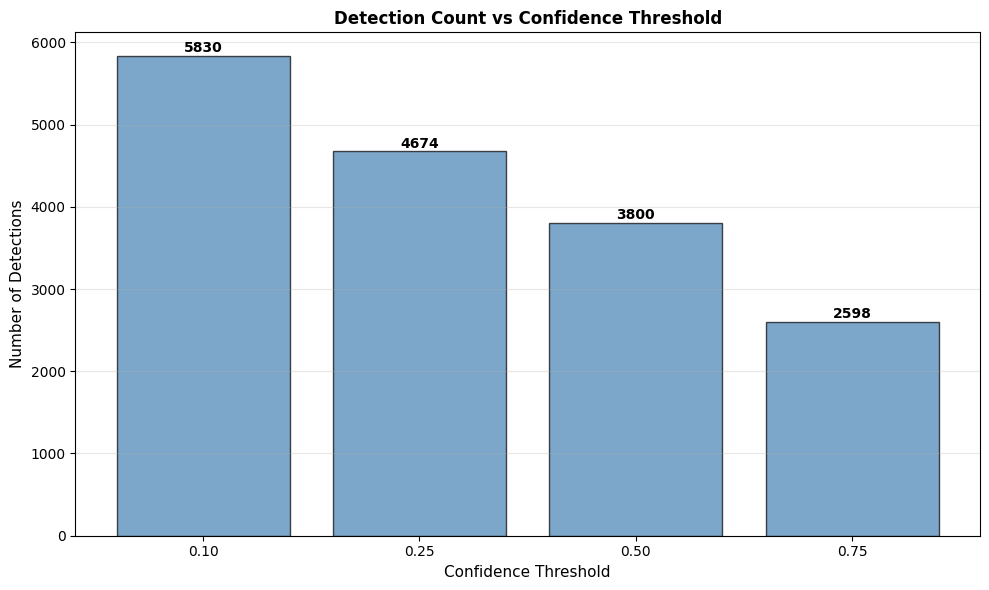

✓ Confidence threshold analysis visualized and saved


In [20]:
# Analyze impact of confidence thresholds
confidence_thresholds = [0.1, 0.25, 0.5, 0.75]
threshold_stats = []

print("Analyzing confidence thresholds...")
print("=" * 60)

for conf_thresh in confidence_thresholds:
    total_detections = 0
    confidences = []

    for img_path in test_images:
        results = model(str(img_path), conf=conf_thresh, iou=0.45)
        for result in results:
            total_detections += len(result.boxes)
            for box in result.boxes:
                confidences.append(float(box.conf))

    threshold_stats.append({
        'Confidence Threshold': f'{conf_thresh:.2f}',
        'Total Detections': total_detections,
        'Avg Confidence': np.mean(confidences) if confidences else 0,
        'Min Confidence': np.min(confidences) if confidences else 0
    })

threshold_df = pd.DataFrame(threshold_stats)
print("Confidence Threshold Analysis:")
print(threshold_df.to_string(index=False))
print("=" * 60)

# Visualize threshold impact
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(threshold_df['Confidence Threshold'], threshold_df['Total Detections'],
       color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Confidence Threshold', fontsize=11)
ax.set_ylabel('Number of Detections', fontsize=11)
ax.set_title('Detection Count vs Confidence Threshold', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(threshold_df['Total Detections']):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('confidence_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confidence threshold analysis visualized and saved")

## Per-Class Performance

Analyzing detection statistics for each PPE class to identify which objects the model detects most reliably and which are challenging.


Per-Class Detection Statistics:
         Class  Detections  Avg Confidence  Min Confidence  Max Confidence  Std Confidence
       Hardhat         414        0.704499        0.251580        0.923595        0.170359
     Machinery         933        0.809061        0.252562        0.982970        0.173090
          Mask         423        0.675520        0.259912        0.958120        0.178960
    NO-Hardhat         151        0.769410        0.275250        0.906451        0.148026
       NO-Mask        1139        0.724105        0.251158        0.983392        0.200063
NO-Safety Vest         371        0.580241        0.254897        0.886432        0.183630
        Person         366        0.597796        0.251512        0.940575        0.196859
   Safety Cone         418        0.717120        0.251218        0.974453        0.171894
   Safety Vest         234        0.655648        0.251247        0.904082        0.187172
       Vehicle         225        0.713462        0.25199

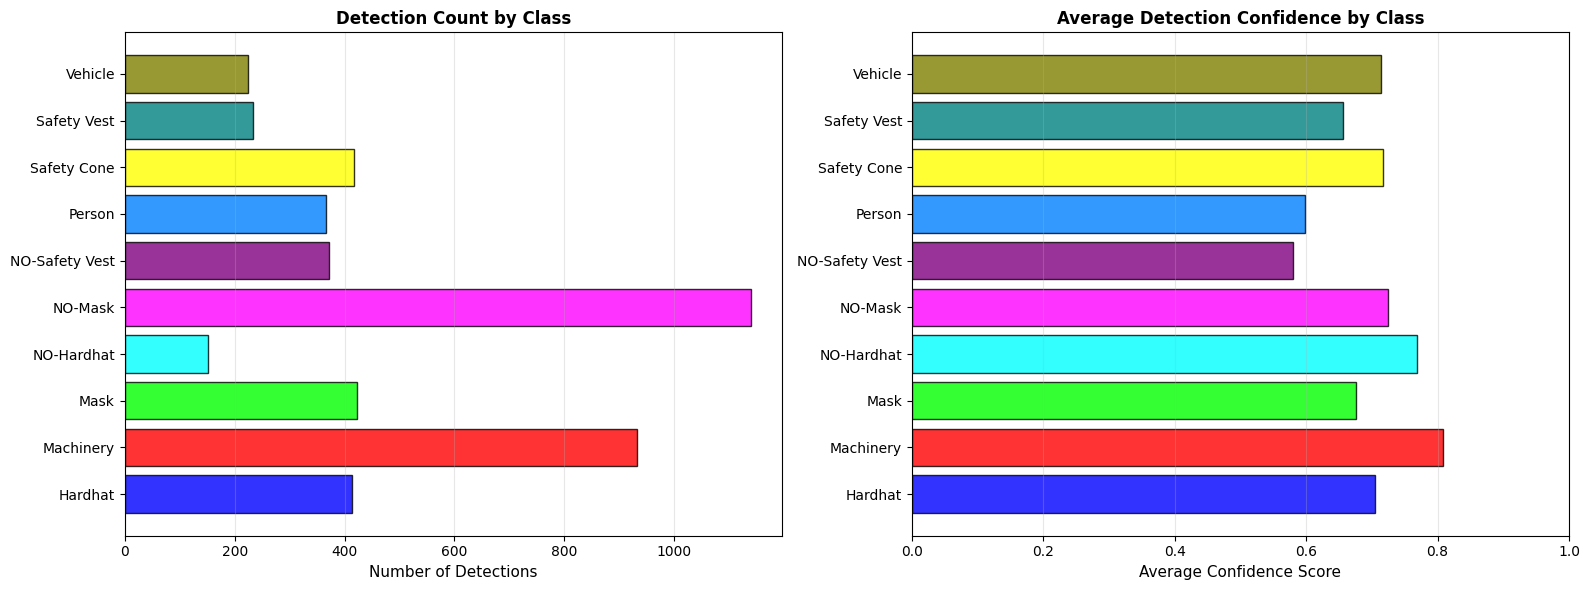

✓ Per-class metrics visualized and saved as 'per_class_metrics.png'


In [21]:
# Calculate per-class detection metrics
class_detection_counts = defaultdict(int)
class_avg_confidence = defaultdict(list)

for pred in predictions:
    class_detection_counts[pred['class_name']] += 1
    class_avg_confidence[pred['class_name']].append(pred['confidence'])

# Compute comprehensive per-class statistics
class_stats = []
for class_name in sorted(class_detection_counts.keys()):
    count = class_detection_counts[class_name]
    confidences = class_avg_confidence[class_name]

    class_stats.append({
        'Class': class_name,
        'Detections': count,
        'Avg Confidence': np.mean(confidences),
        'Min Confidence': np.min(confidences),
        'Max Confidence': np.max(confidences),
        'Std Confidence': np.std(confidences)
    })

class_stats_df = pd.DataFrame(class_stats)
print("\nPer-Class Detection Statistics:")
print("=" * 60)
print(class_stats_df.to_string(index=False))
print("=" * 60)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = [class_colors[i] for i in range(10)]
colors_normalized = [(c[2]/255, c[1]/255, c[0]/255) for c in colors]

# Detection counts
axes[0].barh(class_stats_df['Class'], class_stats_df['Detections'],
            color=colors_normalized, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Number of Detections', fontsize=11)
axes[0].set_title('Detection Count by Class', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# Average confidence
axes[1].barh(class_stats_df['Class'], class_stats_df['Avg Confidence'],
            color=colors_normalized, edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Average Confidence Score', fontsize=11)
axes[1].set_xlim(0, 1)
axes[1].set_title('Average Detection Confidence by Class', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Per-class metrics visualized and saved as 'per_class_metrics.png'")

## Section 8: Confidence Distribution Analysis

Visualize the distribution of confidence scores to understand model certainty in its predictions.

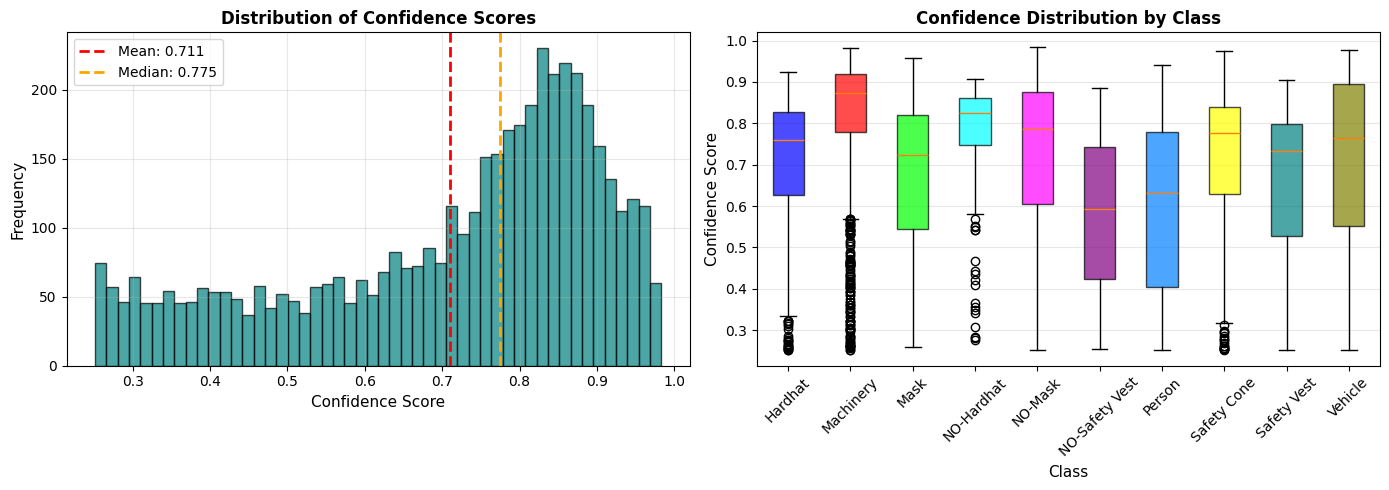

✓ Confidence distribution visualized and saved


In [22]:
# Analyze confidence score distribution
all_confidences = [p['confidence'] for p in predictions]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(all_confidences, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Confidence Scores', fontsize=12, fontweight='bold')
axes[0].axvline(np.mean(all_confidences), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(all_confidences):.3f}')
axes[0].axvline(np.median(all_confidences), color='orange', linestyle='--',
                linewidth=2, label=f'Median: {np.median(all_confidences):.3f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by class
class_confidence_data = []
class_labels = []
for class_name in sorted(class_detection_counts.keys()):
    class_confidence_data.append(class_avg_confidence[class_name])
    class_labels.append(class_name)

bp = axes[1].boxplot(class_confidence_data, labels=class_labels, vert=True, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_normalized):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel('Class', fontsize=11)
axes[1].set_ylabel('Confidence Score', fontsize=11)
axes[1].set_title('Confidence Distribution by Class', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confidence distribution visualized and saved")

## Section 9: Failure Case Analysis

Identify and visualize images where the model struggles (low confidence detections or missed objects). This helps us understand the model's limitations and potential areas for improvement.

Challenging Cases Analysis:
Images with low confidence detections (<0.5): 308

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/003184_jpg.rf.e7b83a5faa2513c5d2201944e2b2bd17.jpg: 640x640 3 Masks, 6 NO-Masks, 3 Machinerys, 1 Vehicle, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/005310_jpg.rf.3fadf8fa69fb354db06bed4e42142276.jpg: 640x640 3 Hardhats, 1 NO-Safety Vest, 3 Masks, 4 NO-Masks, 1 Safety Cone, 1 Machinery, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/PPE_Project/dataset_resplit/images/test/005310_jpg.rf.462b38e32ee1aed612c4ed119dc9a06e.jpg: 640x640 1 Hardhat, 5 NO-Masks, 13 Persons, 2 Safety Cones, 1 Machinery, 1 Vehicle, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /co

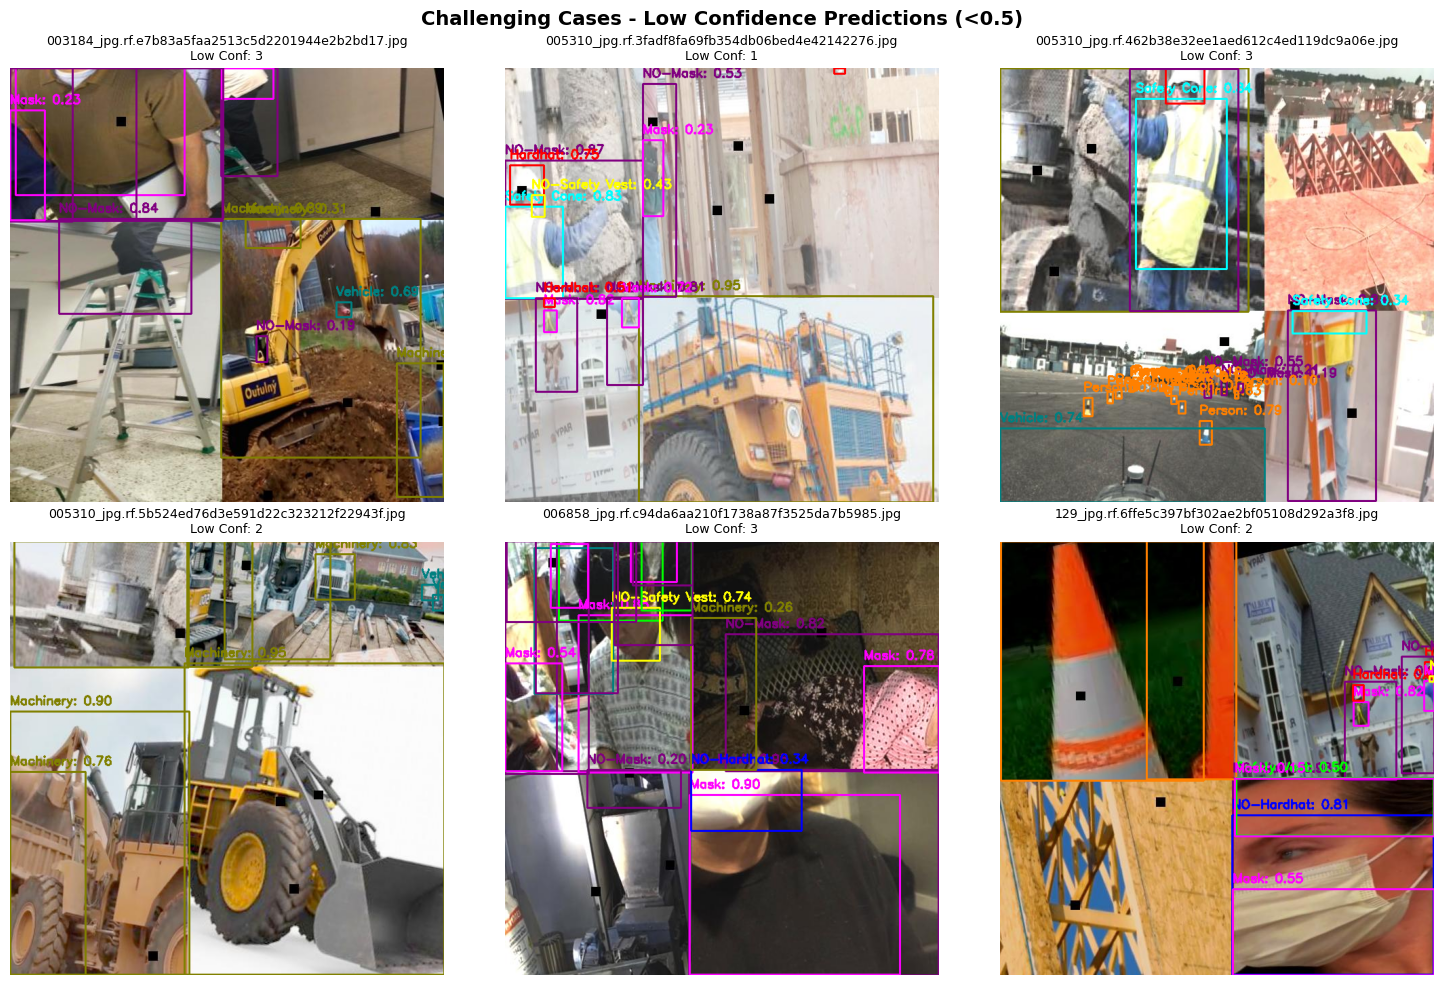

✓ Failure case analysis visualized and saved as 'low_confidence_cases.png'


In [23]:
# Identify challenging cases with low confidence
low_confidence_threshold = 0.5
low_confidence_images = pred_df[pred_df['confidence'] < low_confidence_threshold]['image'].unique()

print(f"Challenging Cases Analysis:")
print("=" * 60)
print(f"Images with low confidence detections (<{low_confidence_threshold}): {len(low_confidence_images)}")
print("=" * 60)

# Visualize challenging cases
if len(low_confidence_images) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Challenging Cases - Low Confidence Predictions (<{low_confidence_threshold})',
                 fontsize=14, fontweight='bold')

    for idx, img_name in enumerate(list(low_confidence_images)[:6]):
        row = idx // 3
        col = idx % 3

        img_path = test_dir / img_name
        results = model(str(img_path), conf=0.1, iou=0.45)  # Lower threshold to see all detections
        pred_img = draw_predictions(str(img_path), results)

        # Count low confidence detections
        low_conf_count = len(pred_df[(pred_df['image'] == img_name) &
                                      (pred_df['confidence'] < low_confidence_threshold)])

        axes[row, col].imshow(pred_img)
        axes[row, col].set_title(f'{img_name}\nLow Conf: {low_conf_count}', fontsize=9)
        axes[row, col].axis('off')

    # Hide empty subplots
    for idx in range(len(low_confidence_images), 6):
        row = idx // 3
        col = idx % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('low_confidence_cases.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Failure case analysis visualized and saved as 'low_confidence_cases.png'")
else:
    print("No low confidence cases found!")

## Section 10: Detection Distribution

Visualize overall distribution of detections across classes to understand which objects are most frequently detected in the test set.

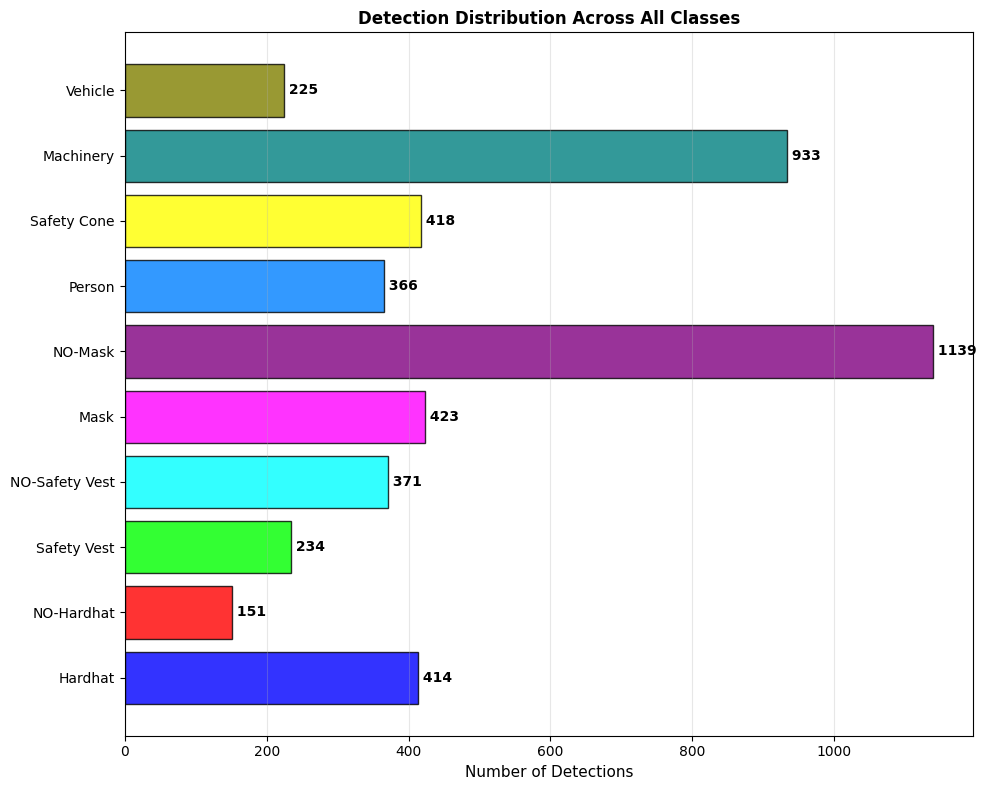

✓ Detection distribution visualized and saved as 'detection_distribution.png'


In [24]:
# Visualize detection distribution
fig, ax = plt.subplots(figsize=(10, 8))

class_names = list(ppe_classes.values())
detection_counts = [class_detection_counts.get(cls, 0) for cls in class_names]

colors_list = [class_colors[i] for i in range(10)]
colors_normalized = [(c[2]/255, c[1]/255, c[0]/255) for c in colors_list]

bars = ax.barh(class_names, detection_counts, color=colors_normalized,
               edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of Detections', fontsize=11)
ax.set_title('Detection Distribution Across All Classes', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

# Add value labels on bars
for bar, count in zip(bars, detection_counts):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f' {count}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('detection_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Detection distribution visualized and saved as 'detection_distribution.png'")

## Section 11: Comprehensive Evaluation Report

Generate final evaluation report with all metrics and statistics.

In [25]:
# Generate comprehensive evaluation summary
summary_report = f"""
================================================================================
YOLOV8 PPE DETECTION MODEL - COMPREHENSIVE EVALUATION REPORT
================================================================================

MODEL INFORMATION:
  Architecture: YOLOv8s (Small) - Maximum Accuracy Configuration
  Input Size: 640x640
  Total Parameters: {sum(p.numel() for p in model.model.parameters()):,}
  Model Path: {model_path}

DATASET STATISTICS:
  Train Images: {len(list(Path('/content/drive/MyDrive/PPE_Project/dataset_resplit/images/train').glob('*.jpg')))}
  Validation Images: {len(list(Path('/content/drive/MyDrive/PPE_Project/dataset_resplit/images/valid').glob('*.jpg')))}
  Test Images: {len(list(Path('/content/drive/MyDrive/PPE_Project/dataset_resplit/images/test').glob('*.jpg')))}
  Number of Classes: 10

OVERALL PERFORMANCE METRICS:
  mAP@50:       {val_results.box.map50:.4f}
  mAP@50-95:    {val_results.box.map:.4f}
  Precision:    {val_results.box.mp:.4f}
  Recall:       {val_results.box.mr:.4f}

TEST SET INFERENCE STATISTICS:
  Total Detections: {len(predictions)}
  Average Confidence: {np.mean(all_confidences):.4f}
  Median Confidence: {np.median(all_confidences):.4f}
  Std Dev Confidence: {np.std(all_confidences):.4f}

PER-CLASS STATISTICS:
{class_stats_df.to_string(index=False)}

CHALLENGING CASES:
  Images with low confidence (<{low_confidence_threshold}): {len(low_confidence_images)}

EVALUATION COMPLETE
================================================================================
"""

print(summary_report)

# Save report to file
with open('/content/evaluation_report.txt', 'w') as f:
    f.write(summary_report)

print("✓ Evaluation report saved to /content/evaluation_report.txt")

print("\n" + "="*70)
print("✓ MODEL EVALUATION COMPLETE")
print("✓ Ready to proceed to Notebook 04: Interactive Demo")
print("="*70)


YOLOV8 PPE DETECTION MODEL - COMPREHENSIVE EVALUATION REPORT

MODEL INFORMATION:
  Architecture: YOLOv8s (Small) - Maximum Accuracy Configuration
  Input Size: 640x640
  Total Parameters: 11,129,454
  Model Path: /content/drive/MyDrive/PPE_Project/runs/detect/ppe_detection4/weights/best.pt
  
DATASET STATISTICS:
  Train Images: 1955
  Validation Images: 0
  Test Images: 423
  Number of Classes: 10
  
OVERALL PERFORMANCE METRICS:
  mAP@50:       0.7710
  mAP@50-95:    0.5006
  Precision:    0.8894
  Recall:       0.6887
  
TEST SET INFERENCE STATISTICS:
  Total Detections: 4674
  Average Confidence: 0.7105
  Median Confidence: 0.7746
  Std Dev Confidence: 0.1970
  
PER-CLASS STATISTICS:
         Class  Detections  Avg Confidence  Min Confidence  Max Confidence  Std Confidence
       Hardhat         414        0.704499        0.251580        0.923595        0.170359
     Machinery         933        0.809061        0.252562        0.982970        0.173090
          Mask         423     